# 线性回归从零开始实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集

为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。我们的合成数据集是一个矩阵 $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$

你可以将 $\epsilon$ 视为捕获特征和标签时的潜在观测误差。在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。下面的代码生成合成数据集。


In [2]:
def synthetic_data(w,b,num_examples):
    """生成 y  = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)

注意，`features` 中的每一行都包含一个二维数据样本，`labels` 中的每一行都包含一维标签值（一个标量）。

In [3]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 0.1448, -0.2330]) 
label: tensor([5.2712])


通过生成第二个特征 `features[:, 1]` 和 `labels` 的散点图，可以直观地观察到两者之间的线性关系。

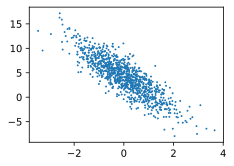

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1);

In [6]:
features

tensor([[ 0.1448, -0.2330],
        [ 0.7598, -1.0402],
        [-1.2343, -0.6317],
        ...,
        [-0.7154, -0.2644],
        [ 1.6309, -0.0705],
        [ 0.5680, -1.3940]])

In [7]:
features.shape

torch.Size([1000, 2])

定义一个`data_iter` 函数实现这一功能。
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量。

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices  =list(range(num_examples))
    #这些样本是随机读取的，没有特定顺序
    random.shuffle(indices)
    for i in range(0,num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.3659,  1.0266],
        [-1.6256, -1.7952],
        [-2.4765, -0.2766],
        [-0.2943, -1.5745],
        [ 0.0955, -0.8815],
        [ 0.8010, -0.8188],
        [ 0.1785, -1.0057],
        [ 0.9220,  0.5016],
        [ 1.0153,  1.2329],
        [-1.8867,  0.2441]]) 
 tensor([[-2.0250],
        [ 7.0503],
        [ 0.1967],
        [ 8.9869],
        [ 7.3965],
        [ 8.5785],
        [ 7.9933],
        [ 4.3244],
        [ 2.0331],
        [-0.4120]])


## 定义 初始化模型参数

在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

In [10]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [11]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X,w) + b

## 定义损失函数

In [12]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## 定义优化算法

In [13]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练过程
现在我们已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。
理解这段代码至关重要，因为在整个深度学习的职业生涯中，你会看到一遍又一遍几乎相同的训练过程。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调用优化算法 `sgd` 来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复，直到完成
    * 计算梯度 $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数 $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用 `data_iter` 函数遍历整个数据集，并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。设置超参数很棘手，需要通过反复试验进行调整。
我们现在忽略这些细节。

In [15]:
lr  = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b),y)# `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l  = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000192
epoch 2, loss 0.000050
epoch 3, loss 0.000049


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [16]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([7.1049e-05, 3.3784e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([-7.2002e-05], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现

In [17]:
import numpy as np
import torch 
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w,true_b,1000)

In [18]:
def load_array(data_arrays,batch_size,is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-0.1772,  1.1763],
         [-0.8471, -0.3050],
         [-1.5692,  0.5632],
         [-1.3451, -0.1118],
         [-0.4005,  0.9672],
         [-0.6579, -0.7498],
         [ 0.6643, -0.5757],
         [ 2.1945, -0.1244],
         [ 0.6432,  0.5398],
         [-0.1126, -0.7639]]),
 tensor([[-0.1655],
         [ 3.5375],
         [-0.8488],
         [ 1.8913],
         [ 0.1015],
         [ 5.4393],
         [ 7.4761],
         [ 9.0039],
         [ 3.6502],
         [ 6.5654]])]

## 使用框架的预定义好的层

In [20]:
from torch import nn

net = nn.Sequential(nn.Linear(2,1))

## 初始化模型参数

In [21]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

计算均方误差使用的是`MSELoss`类，也称为平方 $L_2$ 范数。默认情况下，它返回所有样本损失的平均值。

In [22]:
loss = nn.MSELoss()

## 实例化`SGD`实例

In [23]:
trainter = torch.optim.SGD(net.parameters(), lr = 0.03)

In [25]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainter.zero_grad()
        l.backward()
        trainter.step() #模型更新
    l = loss(net(features),labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000274
epoch 2, loss 0.000108
epoch 3, loss 0.000108


In [26]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0003, -0.0008])
b的估计误差： tensor([0.0009])
